# 決定木モデルによる分類

In [1]:
%matplotlib inline

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('sklearn version : ' + sklearn.__version__)

sklearn version : 0.24.2


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [3]:
tree.score(X_train, y_train)

1.0

In [4]:
tree.score(X_test, y_test)

0.9370629370629371

## 分割時の指標

決定木アルゴリズムが分割を行う際の指標として不純度がある。  
不純度の評価関数を変えることで分割の内容が変化する。

### ジニ不純度
誤分類の確率を指標にしてそれを最小化する。
正解と不正解のノードが同数含まれるときに最大となる。
$$
IG(t) = \sum_{i=0}^{c}p(i|t)(1-p(i|t))
$$
ここで、  
p(i|t)・・・特定のノードtにおいて、iに所属する割合  
c・・・分類数  

### エントロピー不純度
エントロピーを最小化する。
ジニ不純度と同様に正解と不正解のノードが同数含まれるときに最大となる。
$$
IH(t) = -\sum_{i=0}^{c}p(i|t) \log_2 p(i|t)
$$

### 分類誤差
分類の誤差を最小にする。  
ノードのクラス確率の変化にあまり敏感でないため、決定木を成長させるのに適していない。  

## 決定木アルゴリズムの学習

決定木のモデルは可視化を行うことができる。  
このようにすることで多くの人にモデルの内容を知ってもらうことができる。  

決定木モデルをパラメータデフォルト値で行った場合、訓練データの内容を学習するために決定木が複雑になり過学習されることが多い。  
図のsampleはそのモデルに何個のデータが通るかを表し、value=[X,Y]はそのデータがどの割合で2分岐したのかを示す。  
X,Yの差がとても大きく、どちらかが0に近い場合、その分岐があったとしても有効に機能する機会は少なく役に立ちにくい分岐であることがわかる。  
例)  
samples = 142  
vlaue = [134, 8]  

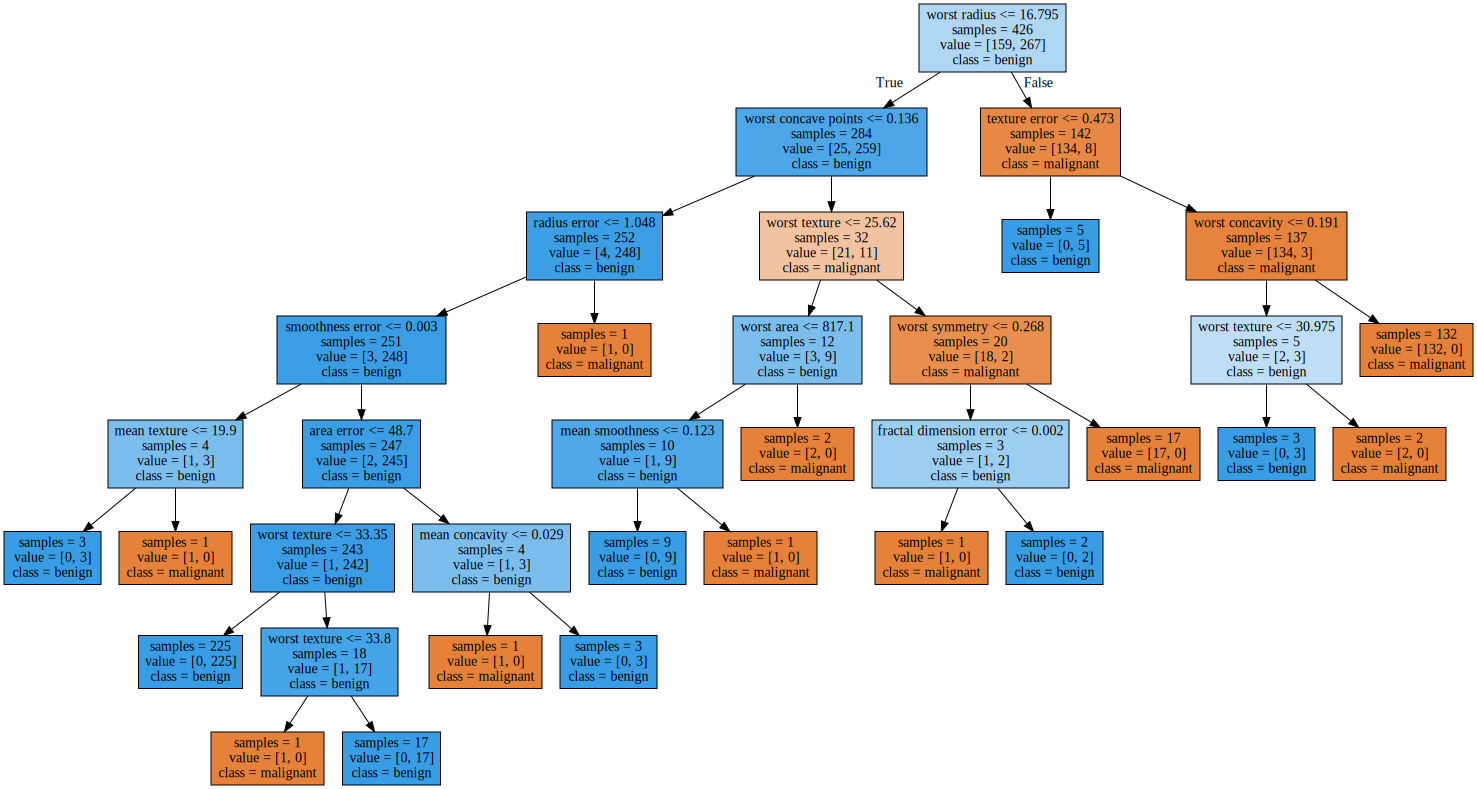

In [5]:
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="data\\tree.dot", class_names=["malignant", "benign"], feature_names=cancer.feature_names, impurity=False, filled=True)

#NOTE: 画像を表示するためには下記URLからgraphvizのexeファイルをダウンロードし、PATHを通しておく必要ある
#下記を参考にする
#https://naonaorange.hatenablog.com/
with open("data\\tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 決定木の深さの制御

決定木アルゴリズムのハイパーパラメータの1つとして決定木の深さがある。  
決定木の深さに指定がない場合は学習データに対して過学習を起こしやすいため適切な値に設定することが多い。  
sklearnでは引数として指定するだけで変更することが可能。 

In [6]:
tree2 = DecisionTreeClassifier(max_depth=2, random_state=0)
tree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

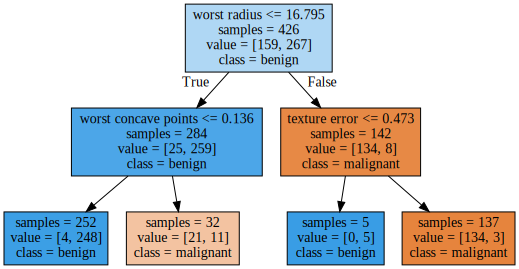

In [7]:
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(tree2, out_file="data\\tree2.dot", class_names=["malignant", "benign"], feature_names=cancer.feature_names, impurity=False, filled=True)

#NOTE: 画像を表示するためには下記URLからgraphvizのexeファイルをダウンロードし、PATHを通しておく必要ある
#下記を参考にする
#https://naonaorange.hatenablog.com/
with open("data\\tree2.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 交差検証によるハイパーパラメータの決定

決定木アルゴリズムには決定木の深さ以外にも設定されるハイパーパラメータがある。  
- max_depth : 決定木の最大深さ
- min_samples_leaf : 葉ノードの最小サンプル個数

ここでハイパーパラメータの値をどのように決定するのかが重要となるが、  
交差検証を用いてテストデータの評価値が一番低くなる値に決定することが一般的

sklearnでは交差検証を用いて最適なパラメータを決定するGridSearchCVがある。  

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
    "max_depth": [1,2,3,4,5,6,7,8,9,10]    
    }
]

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameter : ', grid_search.best_params_)
print('Best parameter score : ', grid_search.best_score_)

Best parameter :  {'max_depth': 3, 'min_samples_leaf': 2}
Best parameter score :  0.9413679890560875


最終結果だけではなく各パラメータのScoreをヒートマップで表示することも可能。  
ヒートマップからもdepth: 3, leaf: 2が最良であることがわかる。

<AxesSubplot:>

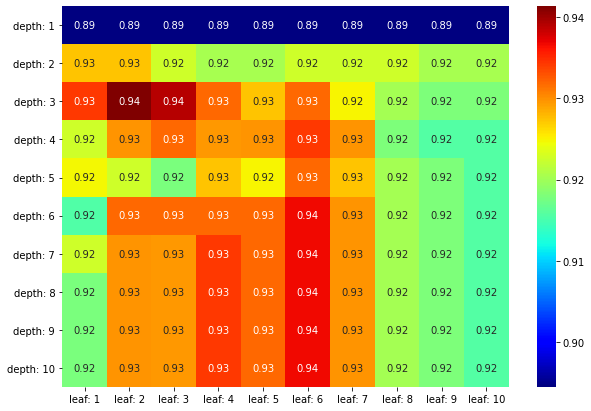

In [9]:
import seaborn as sns

scores = np.array(grid_search.cv_results_['mean_test_score'])
scores = scores.reshape(len(param_grid[0]['max_depth']), len(param_grid[0]['min_samples_leaf']))

clm = ['leaf: ' + str(i) for i in param_grid[0]['min_samples_leaf']]
idx = ['depth: ' + str(i) for i in param_grid[0]['max_depth']]
scores = pd.DataFrame(scores, columns=clm, index=idx)

plt.figure(figsize=(10,7))
sns.heatmap(scores, annot=True, cmap="jet")

In [10]:
pred_y_test = grid_search.predict(X_test)
print((y_test == pred_y_test).mean())

0.9440559440559441


## 特徴量の重要性の確認

特徴量のどの分岐が分類にとって重要なのかを確認することができる。  
これは決定木アルゴリズムを使用しない場合でも、重要な特徴量を可視化する方法として有益である。  

In [11]:
tree.feature_importances_

array([0.        , 0.00752597, 0.        , 0.        , 0.00903116,
       0.        , 0.00752597, 0.        , 0.        , 0.        ,
       0.00975731, 0.04630969, 0.        , 0.00238745, 0.00231135,
       0.        , 0.        , 0.        , 0.        , 0.00668975,
       0.69546322, 0.05383211, 0.        , 0.01354675, 0.        ,
       0.        , 0.01740312, 0.11684357, 0.01137258, 0.        ])

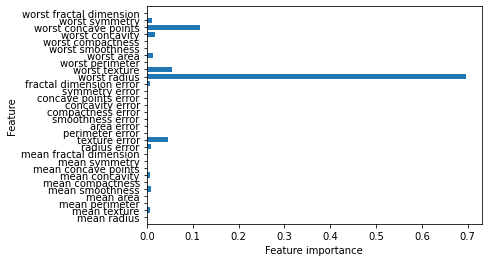

In [12]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)